<p style="font-size:32px;text-align:center"> <b>Social network Graph Link Prediction - Facebook Challenge</b> </p>

In [1]:
#Importing Libraries
# please do go through this python notebook: 
import warnings
warnings.filterwarnings("ignore")

import csv
import pandas as pd#pandas to create small dataframes 
import datetime #Convert to unix time
import time #Convert to unix time
# if numpy is not installed already : pip3 install numpy
import numpy as np#Do aritmetic operations on arrays
# matplotlib: used to plot graphs
import matplotlib
import matplotlib.pylab as plt
import seaborn as sns#Plots
from matplotlib import rcParams#Size of plots  
from sklearn.cluster import MiniBatchKMeans, KMeans#Clustering
import math
import pickle
import os
# to install xgboost: pip3 install xgboost
import xgboost as xgb

import warnings
import networkx as nx
import pdb
import pickle
from pandas import HDFStore,DataFrame
from pandas import read_hdf
from scipy.sparse.linalg import svds, eigs
import gc
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

In [ ]:
#!wget --header="Host: doc-0o-bk-docs.googleusercontent.com" --header="User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/90.0.4430.212 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header="Accept-Language: en-US,en;q=0.9" --header="Cookie: AUTH_nso6dcn1mbidkt5qr539a2jiefc09pqv_nonce=iak2ig7rpq664" --header="Connection: keep-alive" "https://doc-0o-bk-docs.googleusercontent.com/docs/securesc/nss2f5s2soorprev6d4t4qp3n5ekp9nh/evl2j2j4t5hronicnhsbdlsblnbl9qk3/1622116650000/06629147635963609455/13017565264516993811/1fDJptlCFEWNV5UNGPc4geTykgFI3PDCV?e=download&authuser=0&nonce=iak2ig7rpq664&user=13017565264516993811&hash=fvl5s6dohfnqle6k8q3koe9jr2mhe6jr" -c -O 'storage_sample_stage4.h5'

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
hdf_path = r'/content/drive/MyDrive/AAIML/17_fb_link_pred/data/fea_sample'

In [4]:
#reading
from pandas import read_hdf
df_final_train = read_hdf(fr'{hdf_path}/storage_sample_stage4.h5', 'train_df',mode='r')
df_final_test = read_hdf(fr'{hdf_path}/storage_sample_stage4.h5', 'test_df',mode='r')

In [ ]:
# #reading
# from pandas import read_hdf
# df_final_train = read_hdf('storage_sample_stage4.h5', 'train_df',mode='r')
# df_final_test = read_hdf('storage_sample_stage4.h5', 'test_df',mode='r')

In [5]:
df_final_train.columns

Index(['source_node', 'destination_node', 'indicator_link',
       'jaccard_followers', 'jaccard_followees', 'cosine_followers',
       'cosine_followees', 'num_followers_s', 'num_followees_s',
       'num_followees_d', 'inter_followers', 'inter_followees', 'adar_index',
       'follows_back', 'same_comp', 'shortest_path', 'weight_in', 'weight_out',
       'weight_f1', 'weight_f2', 'weight_f3', 'weight_f4', 'page_rank_s',
       'page_rank_d', 'katz_s', 'katz_d', 'hubs_s', 'hubs_d', 'authorities_s',
       'authorities_d', 'svd_u_s_1', 'svd_u_s_2', 'svd_u_s_3', 'svd_u_s_4',
       'svd_u_s_5', 'svd_u_s_6', 'svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3',
       'svd_u_d_4', 'svd_u_d_5', 'svd_u_d_6', 'svd_v_s_1', 'svd_v_s_2',
       'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6', 'svd_v_d_1',
       'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5', 'svd_v_d_6'],
      dtype='object')

**NOTE** :  
As followers for d is missing so we will find them first

In [6]:
eda_path = r'/content/drive/MyDrive/AAIML/17_fb_link_pred/data/after_eda'

Here as Negative Points means missing links between pair of users  
So we will considered Graph structure for positive data points because 
negative & positive samples will have same unique vertex  
& Info such as OutDegree & Indegree can be obtained solely from Connected Graph (ie Positive Samples from Data where edge is present)  
So in this case negative samples are no use for getting followers & followees info  

Hence we are using `train_pos_after_eda.csv` to represent the entire train_graph instead of considering `train_after_eda` for train graph

In [7]:
train_graph=nx.read_edgelist(fr'{eda_path}/train_pos_after_eda.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)

In [ ]:
# Add new column derived from existing column
# ref : https://sparkbyexamples.com/pandas/pandas-add-column-based-on-another-column/

# Below is not working as some destinatio_node are missing in train_Graph (Try runninng below line & you will get idea)
#new_col = df_final_train['destination_node'].apply(train_graph.predecessors)

In [8]:
# https://www.statology.org/pandas-select-rows-based-on-column-values/

df_final_train.loc[df_final_train['destination_node']==94679]

,source_node,destination_node,indicator_link,jaccard_followers,jaccard_followees,cosine_followers,cosine_followees,num_followers_s,num_followees_s,num_followees_d,...,svd_v_s_3,svd_v_s_4,svd_v_s_5,svd_v_s_6,svd_v_d_1,svd_v_d_2,svd_v_d_3,svd_v_d_4,svd_v_d_5,svd_v_d_6
50072,854725,94679,0,0,0.0,0.0,0.0,0,0,0,...,-2.015384e-22,-1.303879e-22,-3.628183e-23,9.020895e-23,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
94679 in train_graph  # Even Though the 94679 is present in dataset its missing in Positive Point Train-Graph Hence its the Person only in Negative Samples

False

Why `94679` Destination Node is Missing in Graph is Questionable because train_graph must include all nodes

(One of the reason may be that because link is missing  
hence it is from negative samples & negative samples may contains some nodes that are not present in positive samples at all)

In [10]:
def nFollowers(nodeId):
  '''Followers := InComing Links to a node '''
  if nodeId not in train_graph: 
    return 0
  return train_graph.in_degree[nodeId]

def nFollowers2(nodeId):
  '''Followers := InComing Links to a node '''
  if nodeId not in train_graph: 
    return 0
  return len(set(train_graph.predecessors(nodeId)))

In [11]:
# FOR CHECKING & TESTING PURPOSE
t1 = df_final_train['destination_node'].apply(nFollowers)
t2 = df_final_train['destination_node'].apply(nFollowers2)

(t1 == t2).all()

True

In [12]:
# # FOR CHECKING & TESTING PURPOSE
t1.count() == df_final_train['destination_node'].count()

True

In [13]:
# Add new column (Followers for Dstination) derived from existing column
# ref : https://sparkbyexamples.com/pandas/pandas-add-column-based-on-another-column

df_final_train['num_followers_d'] = df_final_train['destination_node'].apply(nFollowers)

**NOTE**  
We are using `train_graph` only for test nodes as well because   
- Test Data may contains some nodes which are new
- We have knowledge & access about train data only (ie info about social connections)

In [14]:
df_final_test['num_followers_d'] = df_final_test['destination_node'].apply(nFollowers)

**NOTE :**  
Here the svd featurization should be interpreted as follow :-  
svd_u_s_6   // 6th-dimen val for item's (Source s) repr from Left Singular Matrix (u)

In [15]:
# FOR TESTING PURPOSE ONLY
d1 = len(df_final_train[df_final_train['num_followers_d'] != df_final_train['num_followers_s']])
print('Pair having Different Followers for Source & Destination ', d1)

Pair having Different Followers for Source & Destination  0


In [16]:
# # FOR TESTING PURPOSE ONLY
d2 = len(df_final_train[df_final_train['num_followees_d'] != df_final_train['num_followees_s']])
print('Pair having Different Followees for Source & Destination ', d2)

Pair having Different Followees for Source & Destination  90260


**NOTE (OBSERVANCE)**  
It seems that Followers count for Source & Destination for each pair is same but Followees Count is different in few of them

In [17]:
y_train = df_final_train.indicator_link
y_test = df_final_test.indicator_link

In [18]:
df_final_train.drop(['source_node', 'destination_node','indicator_link'],axis=1,inplace=True)
df_final_test.drop(['source_node', 'destination_node','indicator_link'],axis=1,inplace=True)

---

#### ***New Feature 1 (Preferential Attachment)***
Val := Connection(Source) * Connection(Destination)

### Preferential Attachment  
Add another feature called Preferential Attachment with followers and followees data of vertex. you can check about Preferential Attachment in below link http://be.amazd.com/link-prediction/



In [19]:
feat_name = 'preferential_attachment'

In [20]:
df_final_train[feat_name] = df_final_train['num_followees_s'] * df_final_train['num_followees_d']

df_final_train[[feat_name]].head(3)

,preferential_attachment
0,120
1,8662
2,902


In [21]:
df_final_test[feat_name] = df_final_test['num_followees_s'] * df_final_test['num_followees_d']

#### ***New Feature 2 (SVD_DOT)***
Each Row is a Pair of 2 Person (follower, followee)  

Now If we build Adjacency Matrix for each Person considering if edge present or not, then we will get a sparse vector for eahc person where size of the vector would be = #unique persons in the graph  

Now We can use SVD technique (for given Adj Matrix) to reduce the dimen of the above vector for each person retaining most info as max as possible  

This way let say if we define k=6 then we will get two 6-dimen vector for each person i.e (6+6 = 12) vals as info for each person  

Lets understand this briefly :   
- 6-dimen from Left Singular Matrix of SVD (ie Matrix Factoriation)
- 6-dimen from Right Singular Matrix of SVD (ie Matrix Factorization)

---
Notation Understanding

U * S * V = SVD(Adj-Matrix)

U -> Left Singular Matrix  
V -> Right Singular Matrix


---
In our Dataframe, we already have these values computed  

Column Name Decoding  

svd_u_s_5 := **5th**-dimen val of 6-dimen vector for `source_node` from Left Singular Matrix `U`  
svd_v_d_3 := **3rd**-dimen val of 6-dimen vector for `destination_node` from Right Singular Matrix `V`  



**PLAYGROUND**  
To test Dot Product of  multiple columns at once for SVD-Dot

In [22]:
# FOR TESTING/CHECKING PURPOSE ONLY
d1 = pd.DataFrame({'c1': [1,2], 'c2': [10, 20], 'c3':[100, 200], 'c4': [50, 500]})
d1

,c1,c2,c3,c4
0,1,10,100,50
1,2,20,200,500


In [23]:
# # FOR TESTING/CHECKING PURPOSE ONLY
s1 = d1.loc[0][['c1', 'c2']]
s1.shape

(2,)

In [24]:
# FOR TESTING/CHECKING PURPOSE ONLY
s2 = d1.loc[0][['c3', 'c4']]
type(s2)

pandas.core.series.Series

In [25]:
# FOR TESTING/CHECKING PURPOSE ONLY
np.dot(s1, s2)

600

In [26]:
# FOR TESTING/CHECKING PURPOSE ONLY
def f(row):
  return np.dot(row[['c1', 'c2']], row[['c3', 'c4']])

d1['c5'] = d1.apply(f, axis=1)
d1

,c1,c2,c3,c4,c5
0,1,10,100,50,600
1,2,20,200,500,10400


#### SVD-Dot Feature

Add  feature called svd_dot. you can calculate svd_dot as Dot product between sourse node svd and destination node svd features.  you can read about this in below pdf 
https://storage.googleapis.com/kaggle-forum-message-attachments/2594/supervised_link_prediction.pdf<br>

**We get 2 representations for each person**

In [27]:
feat_name = 'svd_dot'

In [28]:
def calc_svd_dot(row):

  src_v1 = [f'svd_u_s_{i}' for i in range(1, 7)] # 6-dimen vector from Left Singular Matrix U
  src_v2 = [f'svd_v_s_{i}' for i in range(1, 7)] # 6-dimen vector from right Singular Matrix V

  src_v = [*src_v1, *src_v2]

  dst_v1 = [f'svd_u_d_{i}' for i in range(1, 7)] # 6-dimen vector from Left Singular Matrix U
  dst_v2 = [f'svd_v_d_{i}' for i in range(1, 7)] # 6-dimen vector from right Singular Matrix V

  dst_v = [*dst_v1, *dst_v2]

  return np.dot(row[src_v], row[dst_v])

In [29]:
# https://sparkbyexamples.com/pandas/pandas-add-column-based-on-another-column/
df_final_train[feat_name] = df_final_train.apply(calc_svd_dot, axis=1)

df_final_train[[feat_name]].head(3)

,svd_dot
0,1.338835e-11
1,4.099684e-03
2,2.034290e-35


In [30]:
df_final_test[feat_name] = df_final_test.apply(calc_svd_dot, axis=1)

Estimators =  10 Train Score 0.916574881203386 test Score 0.8791390009981339
Estimators =  50 Train Score 0.919380817906077 test Score 0.9128689988444164
Estimators =  100 Train Score 0.9193735438237229 test Score 0.9086616496975063
Estimators =  250 Train Score 0.9210740779437886 test Score 0.9157020634121791
Estimators =  450 Train Score 0.921750039203387 test Score 0.9137760575527463


Text(0.5, 1.0, 'Estimators vs score at depth of 5')

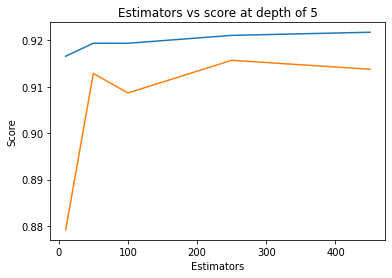

In [31]:
estimators = [10,50,100,250,450]
train_scores = []
test_scores = []
for i in estimators:
    clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, 
            #min_impurity_split=None,
            min_samples_leaf=52, 
            min_samples_split=120,
            min_weight_fraction_leaf=0.0, n_estimators=i, n_jobs=-1,random_state=25,verbose=0,warm_start=False)
    clf.fit(df_final_train,y_train)
    train_sc = f1_score(y_train,clf.predict(df_final_train))
    test_sc = f1_score(y_test,clf.predict(df_final_test))
    test_scores.append(test_sc)
    train_scores.append(train_sc)
    print('Estimators = ',i,'Train Score',train_sc,'test Score',test_sc)
plt.plot(estimators,train_scores,label='Train Score')
plt.plot(estimators,test_scores,label='Test Score')
plt.xlabel('Estimators')
plt.ylabel('Score')
plt.title('Estimators vs score at depth of 5')

depth =  3 Train Score 0.8866686956247967 test Score 0.8662080164088539
depth =  9 Train Score 0.9581065765425418 test Score 0.9228265922826593
depth =  11 Train Score 0.9611498505763485 test Score 0.9198155122075065
depth =  15 Train Score 0.9648505259740918 test Score 0.9167782666921752
depth =  20 Train Score 0.963869617771638 test Score 0.9247920273637095
depth =  35 Train Score 0.964070456462744 test Score 0.9249456051036143
depth =  50 Train Score 0.964070456462744 test Score 0.9249456051036143
depth =  70 Train Score 0.964070456462744 test Score 0.9249456051036143
depth =  130 Train Score 0.964070456462744 test Score 0.9249456051036143


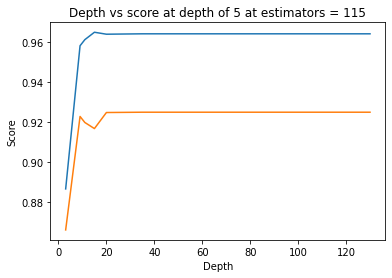

In [33]:
depths = [3,9,11,15,20,35,50,70,130]
train_scores = []
test_scores = []
for i in depths:
    clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=i, max_features='auto', 
            max_leaf_nodes=None,
            min_impurity_decrease=0.0, 
            #min_impurity_split=None,
            min_samples_leaf=52, min_samples_split=120,
            min_weight_fraction_leaf=0.0, n_estimators=115, n_jobs=-1,random_state=25,verbose=0,warm_start=False)
    clf.fit(df_final_train,y_train)
    train_sc = f1_score(y_train,clf.predict(df_final_train))
    test_sc = f1_score(y_test,clf.predict(df_final_test))
    test_scores.append(test_sc)
    train_scores.append(train_sc)
    print('depth = ',i,'Train Score',train_sc,'test Score',test_sc)
plt.plot(depths,train_scores,label='Train Score')
plt.plot(depths,test_scores,label='Test Score')
plt.xlabel('Depth')
plt.ylabel('Score')
plt.title('Depth vs score at depth of 5 at estimators = 115')
plt.show()

In [35]:
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from scipy.stats import uniform

param_dist = {"n_estimators":sp_randint(105,125),
              "max_depth": sp_randint(10,15),
              "min_samples_split": sp_randint(110,190),
              "min_samples_leaf": sp_randint(25,65)}

clf = RandomForestClassifier(random_state=25,n_jobs=-1)

rf_random = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=5,cv=10,scoring='f1',random_state=25, 
                                  return_train_score=True
                                  )

rf_random.fit(df_final_train,y_train)
print('mean test scores',rf_random.cv_results_['mean_test_score'])
print('mean train scores',rf_random.cv_results_['mean_train_score'])

mean test scores [0.96228784 0.96165159 0.96020582 0.96195035 0.96384623]
mean train scores [0.96302613 0.96249264 0.96086972 0.96267275 0.9648021 ]


In [36]:
print(rf_random.best_estimator_)

RandomForestClassifier(max_depth=14, min_samples_leaf=28, min_samples_split=111,
                       n_estimators=121, n_jobs=-1, random_state=25)


In [38]:
clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=14, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, 
            #min_impurity_split=None,
            min_samples_leaf=28, min_samples_split=111,
            min_weight_fraction_leaf=0.0, n_estimators=121, n_jobs=-1,
            oob_score=False, random_state=25, verbose=0, warm_start=False)

In [39]:
clf.fit(df_final_train,y_train)
y_train_pred = clf.predict(df_final_train)
y_test_pred = clf.predict(df_final_test)

In [40]:
from sklearn.metrics import f1_score
print('Train f1 score',f1_score(y_train,y_train_pred))
print('Test f1 score',f1_score(y_test,y_test_pred))

Train f1 score 0.9644531963702064
Test f1 score 0.9129052222720191


In [41]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    
    A =(((C.T)/(C.sum(axis=1))).T)
    
    B =(C/C.sum(axis=0))
    plt.figure(figsize=(20,4))
    
    labels = [0,1]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

Train confusion_matrix


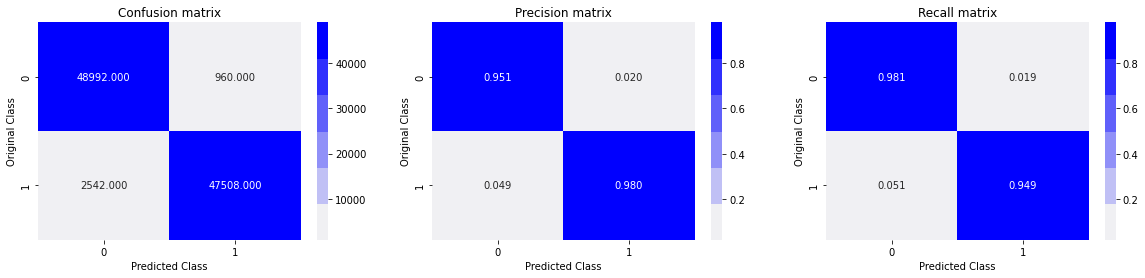

Test confusion_matrix


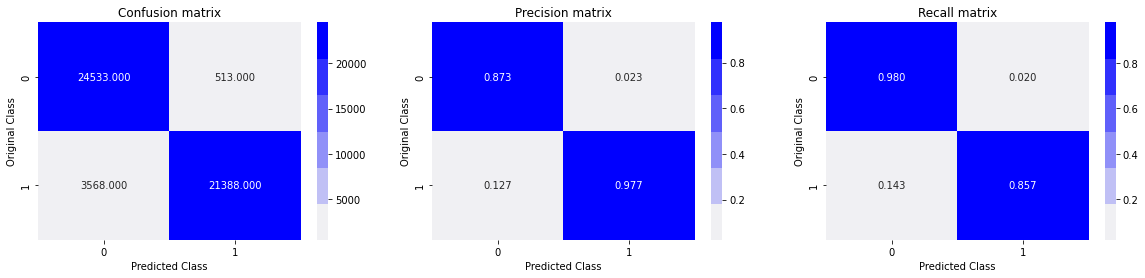

In [42]:
print('Train confusion_matrix')
plot_confusion_matrix(y_train,y_train_pred)
print('Test confusion_matrix')
plot_confusion_matrix(y_test,y_test_pred)

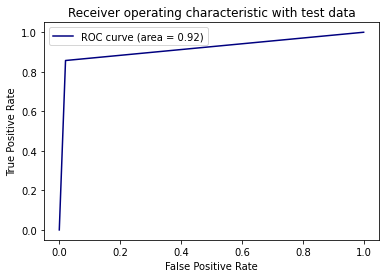

In [43]:
from sklearn.metrics import roc_curve, auc
fpr,tpr,ths = roc_curve(y_test,y_test_pred)
auc_sc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='navy',label='ROC curve (area = %0.2f)' % auc_sc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic with test data')
plt.legend()
plt.show()

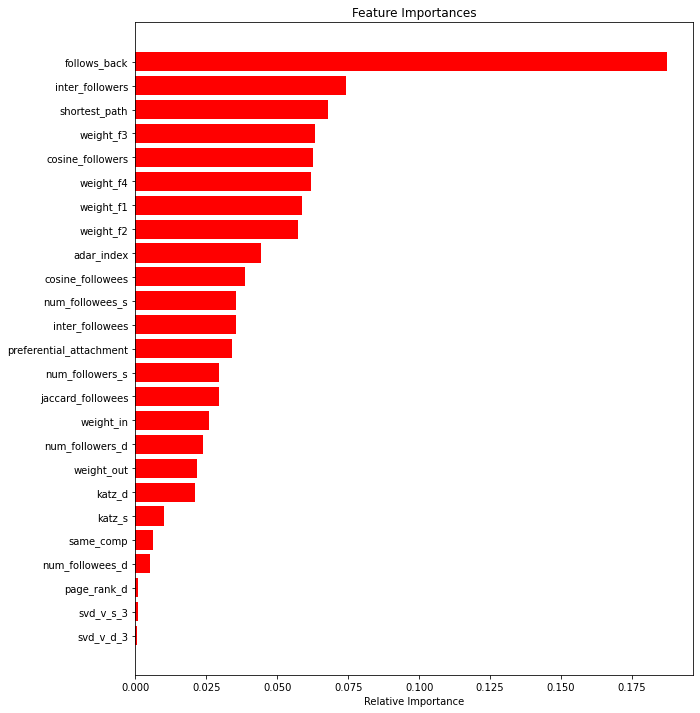

In [44]:
features = df_final_train.columns
importances = clf.feature_importances_
indices = (np.argsort(importances))[-25:]
plt.figure(figsize=(10,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()